# Ingredients Prediction

* In this notebook we are going to build a model that will try to predict how many ingredients a  
pizza shop is going to use in a given week, wich will help them prepare their stock with enough antelation

* The idea is to first try to predict the ingredient distriution of a given day, based on data of the past,  
and then sum up all the predictions of one week

* Once we have a model that fits the time series decently, we'll a constant that will make the prediction allways  
above the real value, because it is preferable to have leftovers than lack of stock

## Import Libraries

In [2]:
import json
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

## Load Data

In [3]:
ingredients = pd.read_csv('data/ingredients_per_day_2016.csv', index_col=0)
ingredients.index = pd.to_datetime(ingredients.index)
'''Sort the data by date'''
ingredients = ingredients.sort_index()
ingredients.head()

,Alfredo Sauce,Anchovies,Artichoke,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,...,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,3.0,4.0,24.0,2.0,12.0,22.0,18.0,18.0,6.0,15.0,...,15.0,6.0,15.0,3.0,33.0,10.0,13.0,0.0,139.0,7.0
2016-01-02,0.0,11.0,55.0,6.0,8.0,16.0,13.0,13.0,10.0,12.0,...,12.0,11.0,12.0,11.0,39.0,6.0,19.0,0.0,165.0,15.0
2016-01-03,3.0,3.0,48.0,11.0,12.0,12.0,16.0,16.0,8.0,12.0,...,12.0,12.0,12.0,3.0,53.0,12.0,12.0,1.0,127.0,18.0
2016-01-04,7.0,7.0,31.0,5.0,17.0,12.0,6.0,6.0,2.0,3.0,...,3.0,5.0,3.0,0.0,25.0,3.0,8.0,0.0,79.0,5.0
2016-01-05,13.0,5.0,34.0,0.0,25.0,11.0,5.0,5.0,4.0,12.0,...,12.0,14.0,12.0,3.0,51.0,6.0,9.0,2.0,83.0,7.0


### Fill Missing Days with previous day

In [4]:
dates = pd.date_range(ingredients.index[0], ingredients.index[-1])
ingredients = ingredients.reindex(dates, method='ffill')

## Prepare Data for Training

We are going to predict the ingredients spent on a given day using the mean of the $d$ inmediate previous days  
and the $w$ same days of the previous w weeks.  
Ej. If we are trying to predict the ingredients of 2016-12-31 we are going to take the mean of the following days ($d=3,w=2$): 
 - 2016-12-30
 - 2016-12-29
 - 2016-12-28
 - 2016-12-24
 - 2016-12-17  

And that is going to be the input to our model, which will output another distribution of ingredients, which is the prediction we are looking for.  

In [5]:
def mean_ingredients_train(day,previous_days=3,previous_weeks=2,verbose=False):
    '''
    Returns the mean of the ingredients of the previous days and the same day of the previous weeks
    '''
    if verbose:
        print('Mean ingredients to train Day: ',day.date())
    last_day = day-pd.Timedelta(days=1)
    pdays = ingredients[day-pd.Timedelta(days=previous_days):last_day]
    if len(pdays) < previous_days and verbose:
        print('Missing data for previous days, expected {} days, got {}'.format(previous_days,len(pdays)))
    for w in range(1,previous_weeks+1):
        date = day-pd.Timedelta(weeks=w)
        if date in ingredients.index:
            pdays = pd.concat([pdays,ingredients[date:date]])
        elif verbose:
            print('Missing data of previous week',date.date())
    if verbose:
        print("Days used for predicting",[str(d.date()) for d in pdays.index])
    if len(pdays) == 0:
        if verbose:
            print('No data available, using mean of all data')
        return ingredients.mean()
    return pdays.mean()

mean_ingredients_train(pd.to_datetime('2016-12-31'))

Alfredo Sauce               2.2
Anchovies                   4.4
Artichoke                  24.6
Arugula                     4.0
Asiago Cheese               9.2
                           ... 
Sun-dried Tomatoes          8.8
Thai Sweet Chilli Sauce     9.2
Thyme                       0.4
Tomatoes                   82.0
Zucchini                    6.4
Length: 64, dtype: float64

In [6]:
X = []
y = []
PREVIOUS_DAYS=2
PREVIOUS_WEEKS=4
for day in ingredients.index:
    X.append(mean_ingredients_train(day,previous_days=PREVIOUS_DAYS,previous_weeks=PREVIOUS_WEEKS))
    y.append(ingredients.loc[day])
# Apend the day of the week and the month as features
X = pd.DataFrame(X,index=ingredients.index)
X['dayofweek'] = X.index.dayofweek
X['month'] = X.index.month
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Data

I opted to use XGBoost, to perform the Regression needed to predict the distribution of ingredients of a given day

In [7]:
model = xgb.XGBRegressor(
    objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,   
    max_depth = 5, alpha = 10, n_estimators = 200
)

model.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

## Testing

* As you can see we get a mean absolute error of 6.66.  
* This means that our model fails to predict the ingredient ditribution with a mean margin of 6.66

In [8]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
maes=abs(y_test-y_pred).mean()
print('Mean squared error: ',mse)
print('Mean absolute error: ',mae)
print('Mean absolute error of each ingredient:')

Mean squared error:  78.23731102669915
Mean absolute error:  5.378411051508895
Mean absolute error of each ingredient:


In [9]:
'''Save the model'''
model.save_model('model/ingredients.model')
model_info = {
    "mse":mse,
    "mae":mae,
    "maes":maes.to_dict(),
    "previous_days":PREVIOUS_DAYS,
    "previous_weeks":PREVIOUS_WEEKS,
    "alpha":0.5,
}
json.dump(model_info,open('model/info.json','w'))

## Predict

* We want our model to be realistic, and that means predicting data of a given week with enough antelation.  
* So we are going to be missing some data between the day we want to know the stock and that week
* To fix that, out prediction is going to be recurrent. That is, we'll also predict the data required to predict  
the week

In [10]:
def mean_ingredients_predict(day,previous_days=3,previous_weeks=2,verbose=False,dataframe=None):
    '''
    Returns the mean of the ingredients of the previous days and the same day of the previous weeks
    '''
    if verbose:
        print('Mean ingredients to train Day: ',day.date())
    start_day = day-pd.Timedelta(days=previous_days)
    last_day = day-pd.Timedelta(days=1)
    pdays = pd.date_range(start_day,last_day)
    '''Append previous weeks'''
    for w in range(previous_weeks,0,-1):
        date = day-pd.Timedelta(weeks=w)
        pdays = pdays.insert(previous_weeks-w,date)
    '''Fill missing data'''
    for day in pdays:
        if day not in dataframe.index:
            if verbose:
                print('Missing previous day:',day.date())
            delta=day-dataframe.index[0]
            if verbose:
                print("Attempting to predict it")
            if delta.days < previous_weeks*7:
                if verbose:
                    print('Not enough data to predict!')
                    print('Returning mean of previous and next days')
                m=1
                try:
                    return (dataframe.loc[day-pd.Timedelta(days=m)]+dataframe.loc[day+pd.Timedelta(days=m)])/(2*m)
                except:
                    if verbose:
                        print('To enought data to calculate mean')
                        print("Returning mean of all data")
                    return dataframe.mean()
            dataframe.loc[day] = predict(day)
    return dataframe.loc[pdays].mean()

def predict(day,verbose=False,dataframe=None):
    '''
    Predict the ingredients for the given day
    Inputs:
        day: datetime object
        verbose: bool
        dataframe: dataframe with the ingredients
    Outputs:
        ingredients: dataframe with the ingredients
    '''
    if dataframe is None:
        dataframe = ingredients
    mean = mean_ingredients_predict(day,verbose=verbose,dataframe=dataframe,previous_days=PREVIOUS_DAYS,previous_weeks=PREVIOUS_WEEKS)
    dayofweek = day.dayofweek
    month = day.month
    X = pd.DataFrame([mean],columns=mean.index)
    X['dayofweek'] = dayofweek
    X['month'] = month
    pred = model.predict(X).tolist()[0]
    return pd.Series(pred,index=mean.index)
predict(pd.to_datetime('2016-01-07'),verbose=True)

Mean ingredients to train Day:  2016-01-07
Missing previous day: 2015-12-10
Attempting to predict it
Not enough data to predict!
Returning mean of previous and next days
To enought data to calculate mean
Returning mean of all data


Alfredo Sauce                3.343781
Anchovies                    5.911858
Artichoke                   30.292011
Arugula                      6.111013
Asiago Cheese               12.839146
                              ...    
Sun-dried Tomatoes           5.885651
Thai Sweet Chilli Sauce     10.482283
Thyme                        1.358407
Tomatoes                   103.008698
Zucchini                     8.660336
Length: 64, dtype: float64

## Visualizations

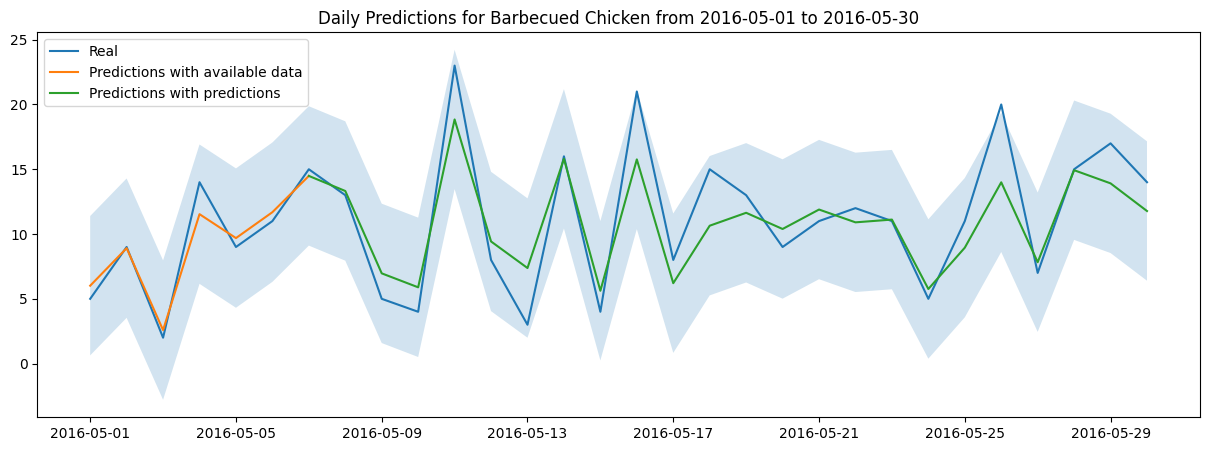

In [26]:
ingredient = 'Barbecued Chicken'
start_prediction = pd.to_datetime('2016-05-01')
end_prediction = pd.to_datetime('2016-05-30')
start_data = pd.to_datetime('2016-03-01')
end_data = pd.to_datetime('2016-05-7')
available_data = ingredients.loc[start_data:end_data].copy()
preds = []
for day in pd.date_range(start_prediction,end_prediction):
    preds.append(predict(day,verbose=False,dataframe=available_data)[ingredient])
preds = pd.Series(preds,index=pd.date_range(start_prediction,end_prediction))
plt.figure(figsize=(15,5))
'''Real Data'''
intersection = pd.date_range(start_prediction,end_prediction).intersection(ingredients.index)
plt.plot(ingredients.loc[intersection,ingredient],label='Real')
'''Predictions from start_data to end_data'''
dates = pd.date_range(start_data,end_data).intersection(pd.date_range(start_prediction,end_prediction))
plt.plot(preds.loc[dates],label='Predictions with available data')
'''Predictions from end_data to end_prediction'''
plt.plot(preds.loc[pd.date_range(end_data,end_prediction)],label='Predictions with predictions')
plt.legend()
'''Area surrounded by the predictions with margin the mean absolute error'''
margin = maes[ingredient]
plt.fill_between(preds.index,preds-mae,preds+mae,alpha=0.2)
plt.title(f'Daily Predictions for {ingredient} from {start_prediction.date()} to {end_prediction.date()}');

## Predict Stock for given Week

* Now we just have to use out model to sum up all values predicted for the given week, increasing the prediction  
of each day by the margin of each ingredient (or the MAE, 6.66) to try to never run out of stock.  
* Using the MAE of each ingredient as margin is more accurate, because each ingredient has its own scale. For  
example, the number of tomatoe used each day is in the order of 1000, so it is intuitive that a wider margin  
should be used in this case.

In [12]:
def predict_stock(monday,margins=None,verbose=False,dataframe=None):
    '''
    Predict the stock for the given week, summing up the ingredients for each day
    Returns: DataFrame with the predicted stock for each ingredient
    '''
    if dataframe is None:
        dataframe = ingredients.copy()
    if margins is None:
        margins = 0
    stock = predict(monday,verbose=verbose,dataframe=dataframe)+margins
    for day in pd.date_range(monday+pd.Timedelta(days=1),monday+pd.Timedelta(days=6)):
        stock += predict(day,verbose=verbose,dataframe=dataframe)+margins
    return stock

def real_stock(monday,dataframe=None):
    '''
    Returns the real stock for the given week
    '''
    if dataframe is None:
        dataframe = ingredients.copy()
    stock = dataframe.loc[monday]
    for day in pd.date_range(monday+pd.Timedelta(days=1),monday+pd.Timedelta(days=6)):
        stock += dataframe.loc[day]
    return stock

dataframe = ingredients[:pd.to_datetime('2016-04-29')].copy()
predict_stock(pd.to_datetime('2016-05-04'),margins=maes,verbose=False,dataframe=dataframe)

Alfredo Sauce               41.125376
Anchovies                   53.851754
Artichoke                  294.296831
Arugula                     48.672486
Asiago Cheese              120.423804
                              ...    
Sun-dried Tomatoes          73.345088
Thai Sweet Chilli Sauce     90.195815
Thyme                       13.510428
Tomatoes                   860.157674
Zucchini                    91.641374
Length: 64, dtype: float64

In [13]:
real_stock(pd.to_datetime('2016-05-04'))

Alfredo Sauce               18.0
Anchovies                   36.0
Artichoke                  267.0
Arugula                     24.0
Asiago Cheese               70.0
                           ...  
Sun-dried Tomatoes          66.0
Thai Sweet Chilli Sauce     68.0
Thyme                        9.0
Tomatoes                   744.0
Zucchini                    66.0
Name: 2016-05-04 00:00:00, Length: 64, dtype: float64

## Visualizations 2

* Now lets visualize how our model really works.
* We'll plot our model prediction of the given ingredients for each week in 2016, using data according to given antelation,  
thus making it more realistic
* For example, with $antelation=4$, to predict the distribution of the week starting on 2016-12-28, we'll use data until 2016-12-23, simulating that we are using this model the previuos Thursday
* Another parameter, $alpha$ is given, to tune how much the margin affects the prediction

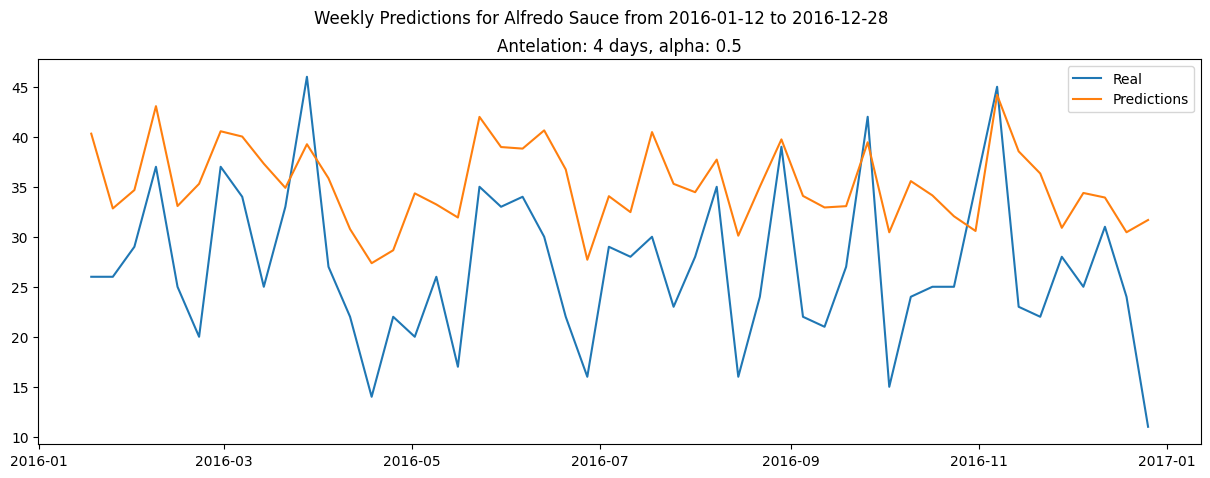

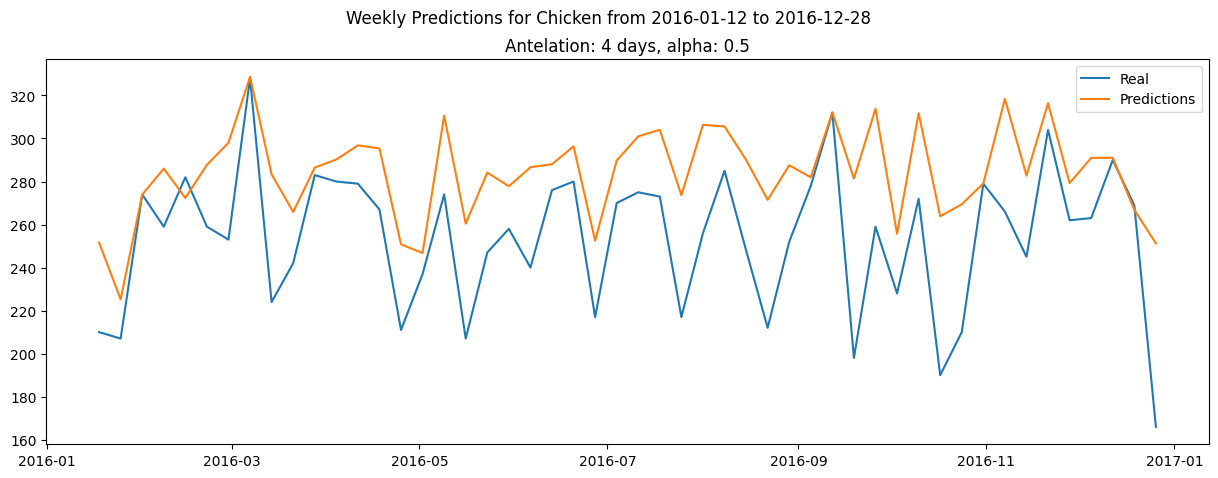

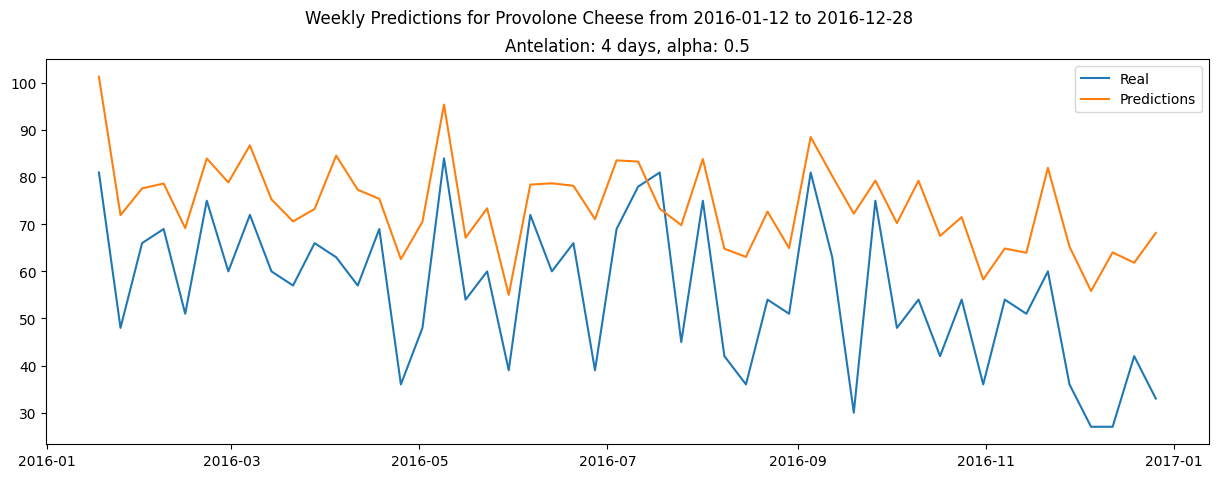

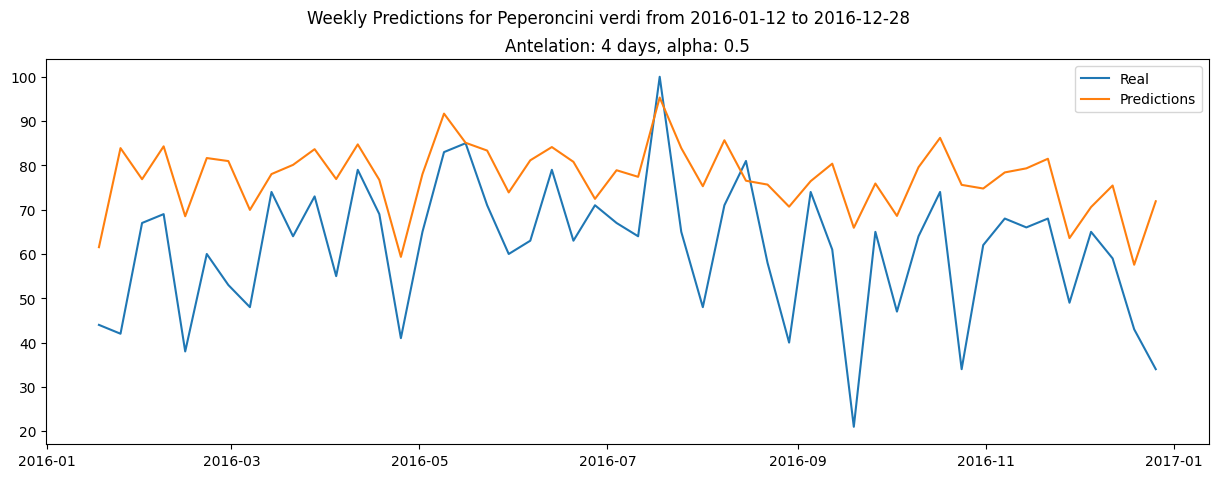

In [25]:
antelation = 4
alpha=0.5
ings=['Alfredo Sauce','Chicken','Provolone Cheese','Peperoncini verdi']
start_prediction = pd.to_datetime('2016-01-12')
end_prediction = pd.to_datetime('2016-12-28')
for ingredient in ings:
    predictions = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        dataframe = ingredients[:monday-pd.Timedelta(days=antelation)].copy()
        predictions.append(predict_stock(monday,margins=maes*alpha,verbose=False,dataframe=dataframe)[ingredient])
    predictions = pd.Series(predictions,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.figure(figsize=(15,5))
    '''Real Data'''
    real = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        count = 0
        for day in pd.date_range(monday,monday+pd.Timedelta(days=6)):
            if day in ingredients.index:
                count += ingredients.loc[day,ingredient]
        real.append(count)
    real = pd.Series(real,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.plot(real,label='Real')
    '''Predictions'''
    plt.plot(predictions,label='Predictions')
    plt.legend()
    plt.suptitle(f'Weekly Predictions for {ingredient} from {start_prediction.date()} to {end_prediction.date()}');
    plt.title(f'Antelation: {antelation} days, alpha: {alpha}');
    plt.show()

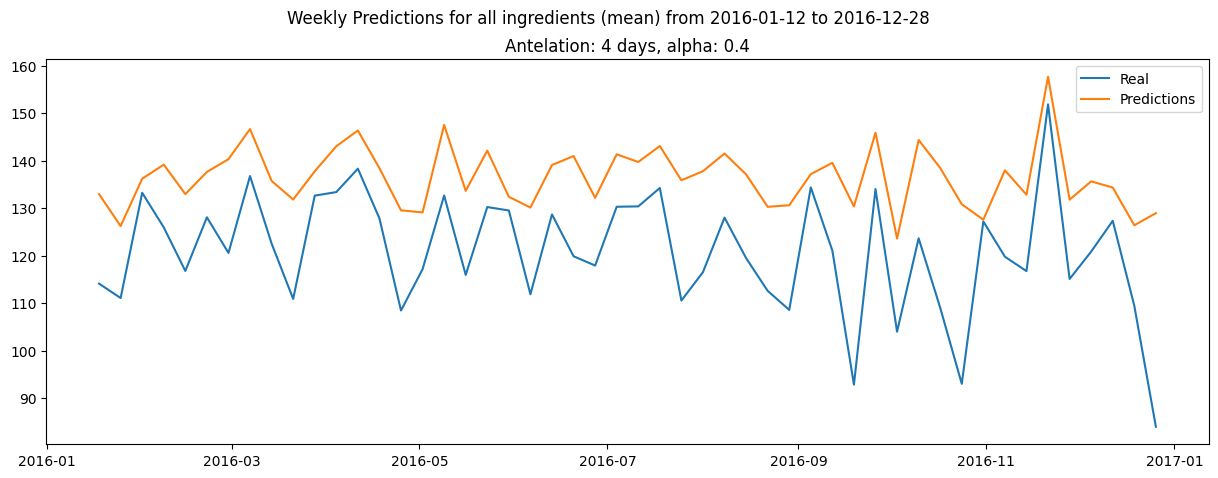

In [22]:
'''plot weekly prediction of mean of ingredients vs real weekly sum of ingredients'''
def plot_weekly_predictions(start_prediction,end_prediction,antelation=4,alpha=0.4):
    predictions = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        dataframe = ingredients[:monday-pd.Timedelta(days=antelation)].copy()
        predictions.append(predict_stock(monday,margins=maes*alpha,verbose=False,dataframe=dataframe).mean())
    predictions = pd.Series(predictions,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.figure(figsize=(15,5))
    '''Real Data'''
    real = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        count = 0
        for day in pd.date_range(monday,monday+pd.Timedelta(days=6)):
            if day in ingredients.index:
                count += ingredients.loc[day].mean()
        real.append(count)
    real = pd.Series(real,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.plot(real,label='Real')
    '''Predictions'''
    plt.plot(predictions,label='Predictions')
    plt.legend()
    plt.suptitle(f'Weekly Predictions for all ingredients (mean) from {start_prediction.date()} to {end_prediction.date()}');
    plt.title(f'Antelation: {antelation} days, alpha: {alpha}')
    plt.show()

plot_weekly_predictions(pd.to_datetime('2016-01-12'),pd.to_datetime('2016-12-28'))